<a href="https://colab.research.google.com/github/yycyy0722/Shopping-Event-Purchase-Prediction/blob/main/BA810_B07_Shopping_Event_Purchase_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shopping Event Purchase Prediction

**Team7: Jooyeon Lee, Yiyou Chen, Xingzhu Chen, Ruoxian Zhang**

**Link: https://colab.research.google.com/drive/1QWjlUz5cHUfmFK7-vSGNeuEs57WTiSY7?usp=sharing**

#Problem Definition:Machine Learning in Action
Using the provided dataset, we aim to classify whether a customer will make a purchase during major shopping events such as Black Friday, Christmas, or outside of these events (None). By leveraging machine learning classification techniques, the firm can accurately categorize customer purchase behaviors and identify key factors that drive purchases during these specific events. This classification approach will not only predict the likelihood of purchases for each event category but also uncover insights that can inform targeted marketing strategies and operational decisions. Our primary goal is to build a robust classification model that uses demographic and purchase-related features to effectively distinguish between these event types and optimize business outcomes.

# Business Problem Goals
*  **Predict Event Category:** Develop a predictive model to determine during which event (Black Friday, Christmas, None) a customer is likely to make a purchase.

* **Identify Key Influencers:** Analyze and identify key demographic, behavioral, and transactional features that influence customer purchases during specific shopping events.

* **Provide Actionable Insights:** Deliver insights to optimize marketing strategies and operational planning for different events, ensuring resource efficiency and maximizing return on investment.

# Business Implications
**Who Cares About This Problem and Why?**

This problem is crucial for retail businesses and marketing teams aiming to enhance customer engagement and boost sales during high-stakes shopping events. By understanding the factors that drive purchases and accurately predicting event-specific behaviors, businesses can:

Tailor marketing campaigns to target high-value customers more effectively.
Allocate resources like inventory, staffing, and logistics more efficiently to meet demand spikes.
Improve customer satisfaction by delivering personalized promotions and seamless shopping experiences.
The ability to anticipate customer behavior during these critical events ensures a competitive edge, drives profitability, and supports long-term customer loyalty.

# Data Source
Christmas sales and Trends: https://onyxdata.co.uk/data-dna-dataset-challenge/datadna-dataset-archive/

The primary data source is the "Christmas Sales Data" from the Data DNA Dataset Archive, which also includes data on other seasonal events.

Dataset Overview:
- Rows: 10,000 customer transactions and satisfaction entries.
- Columns: 25 variables, including categorical features (e.g., event type, delivery type, promotion category) and numerical data (e.g., age, transaction total, satisfaction ratings).

# Step 1: Exploratory Data Analysis (EDA)

Let’s load the dataset and quickly examine it. It’s packed with transactional details like dates, customer demographics, promotions, and even weather conditions. But not everything is equally useful, we decided to drop some columns that were not providing significant predictive power or were highly correlated with other features.
These include: StoreID, ShippingMethod, DeliveryTime, Location, TransactionID, CustomerID, ProductID and ProductName.

Mounted at /content/gdrive
Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionID         10000 non-null  int64  
 1   Date                  10000 non-null  object 
 2   Time                  10000 non-null  object 
 3   CustomerID            10000 non-null  int64  
 4   Age                   10000 non-null  int64  
 5   Gender                10000 non-null  object 
 6   Location              10000 non-null  object 
 7   StoreID               4582 non-null   float64
 8   OnlineOrderFlag       10000 non-null  bool   
 9   ProductID             10000 non-null  int64  
 10  ProductName           10000 non-null  object 
 11  Category              10000 non-null  object 
 12  Quantity              10000 non-null  int64  
 13  UnitPrice             10000 non-null  float64
 14  TotalPrice            10000 n

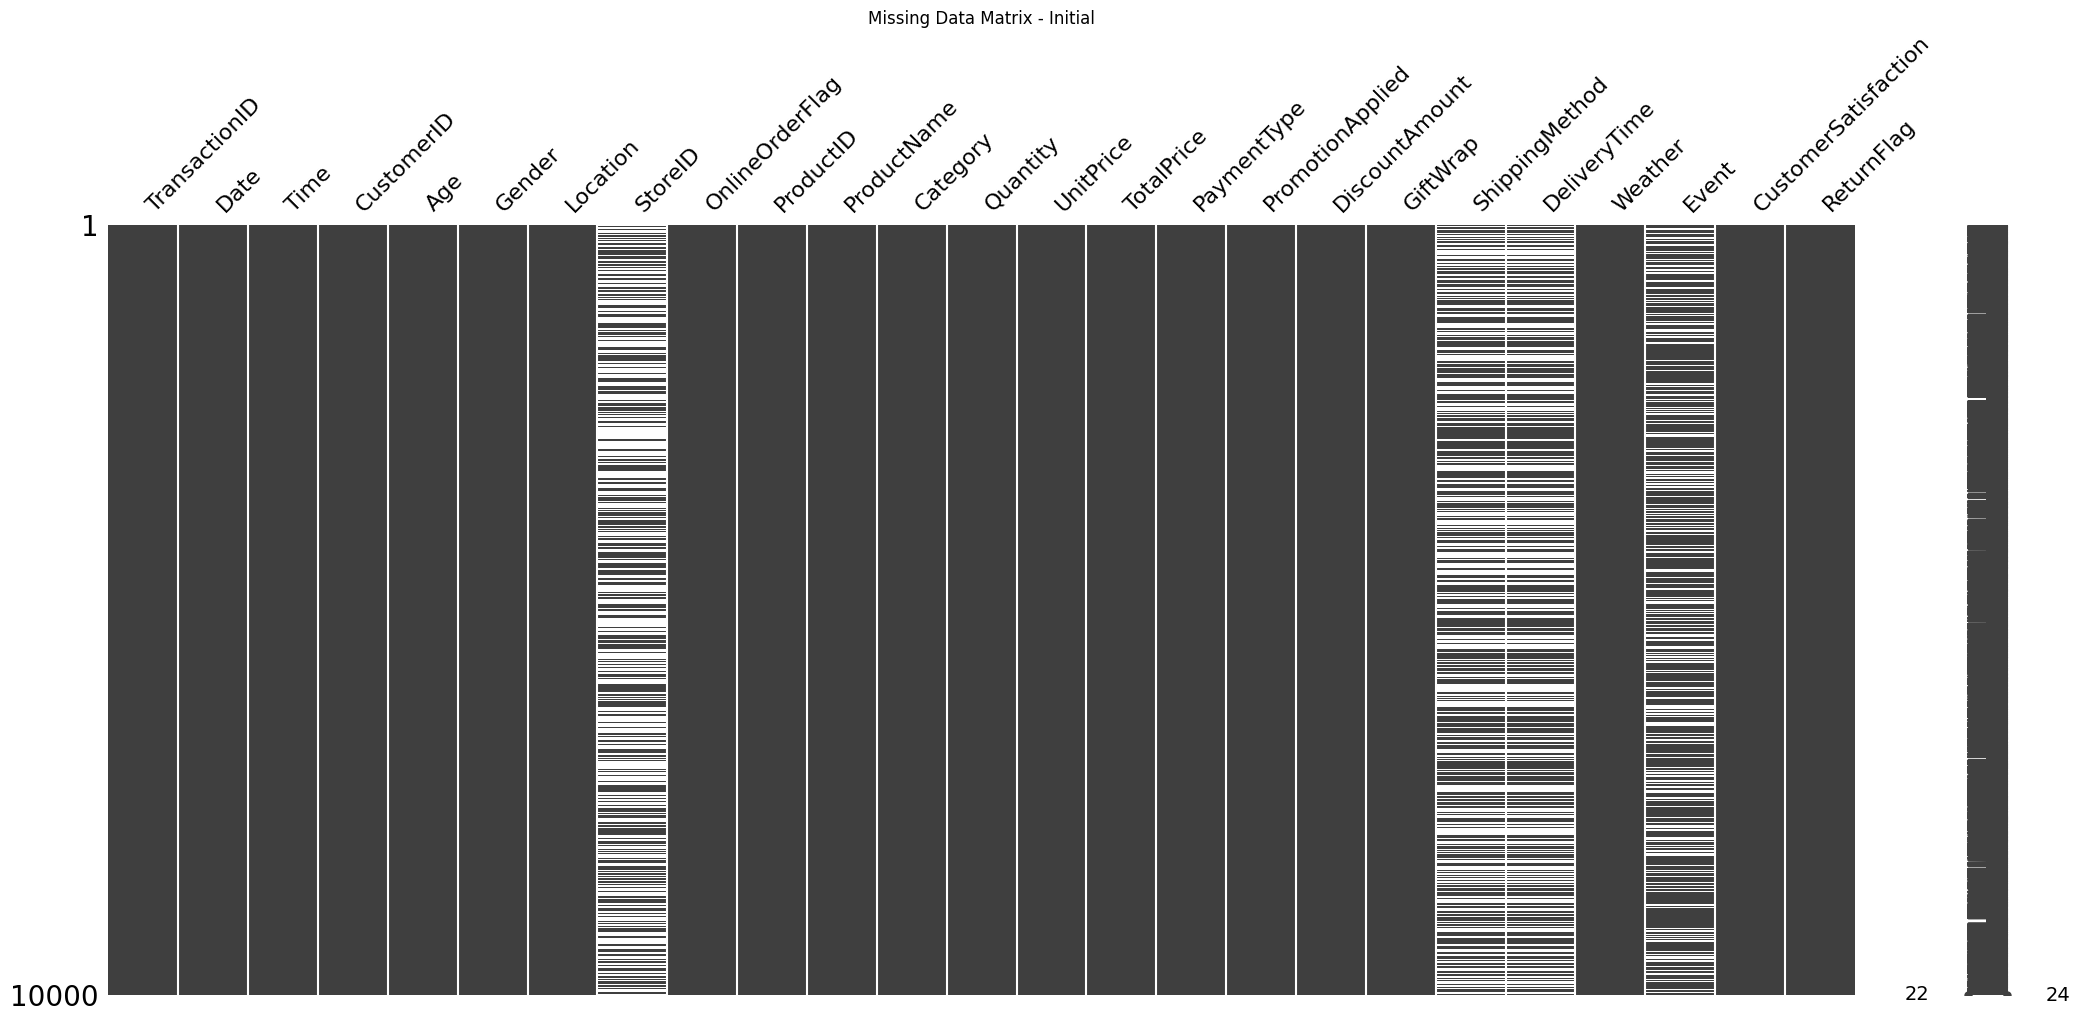

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from google.colab import drive
from sklearn.tree import DecisionTreeClassifier

# Mount Google Drive and load the dataset
drive.mount('/content/gdrive', force_remount=True)
holiday_sales = pd.read_csv('/content/gdrive/MyDrive/810_Group/Christmas_Sales_and_Trends2023.csv')

# Display basic info and summary statistics
print("Data Overview:")
holiday_sales.info()
holiday_sales.describe()

# Visualize missing data
msno.matrix(holiday_sales)
plt.title("Missing Data Matrix - Initial")
plt.show()

We noticed the Date column needed some attention. By parsing it, we extracted valuable details such as the month, day of the week, and even categorized transactions by time of day (morning, afternoon, evening). This helps us identify seasonal and hourly trends.

In [ ]:
# Parse the 'Date' column using the correct MM/DD/YY format
holiday_sales['Date'] = pd.to_datetime(holiday_sales['Date'], format='%m/%d/%y', errors='coerce')

# Add one column called weekday
holiday_sales['Weekday'] = holiday_sales['Date'].dt.day_name()

# fill the NA in Event column by 'Normal Day'
holiday_sales['Event'] = holiday_sales['Event'].fillna('Normal Day')

# Function to update the 'Event' column
def update_event_with_unknown(row):
    if pd.isna(row['Event']):  # Update only if 'Event' is None
        if row['Date'] is not pd.NaT:  # Ensure the date is valid
            if (row['Date'].month == 11 and row['Date'].day >= 1) or (row['Date'].month == 12 and row['Date'].day == 1):
                return 'Black Friday'
            elif (row['Date'].month == 12 and row['Date'].day >= 2) or (row['Date'].month == 1 and row['Date'].day == 1):
                return 'Christmas Market'
        return 'NormalDay'
    return row['Event']

# Apply the function to update the 'Event' column
holiday_sales['Event'] = holiday_sales.apply(update_event_with_unknown, axis=1)

In [ ]:
# Define a function to categorize the time into daytime categories
def categorize_time(row):
    if pd.isna(row['Time']):  # Handle missing time values
        return 'Unknown'
    hour = int(row['Time'].split(':')[0])  # Extract the hour part
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Midnight'

# Apply the function to create the 'Daytime' column
holiday_sales['Daytime'] = holiday_sales.apply(categorize_time, axis=1)
holiday_sales = holiday_sales.drop(columns=['Time'])

Replacing missing values in the 'Event' column with 'Normal Day' ensures consistency in the dataset, making it easier to analyze. It allows us to include all days, even those without specific events, in our analysis. This approach prevents issues that might arise from missing data, ensuring that all entries are accounted for.

In [ ]:
print(holiday_sales['Event'].value_counts())

Event
Black Friday        4254
Christmas Market    2908
Normal Day          2838
Name: count, dtype: int64


Remaining Columns:
Index(['Date', 'Age', 'Gender', 'OnlineOrderFlag', 'Category', 'Quantity',
       'TotalPrice', 'PaymentType', 'PromotionApplied', 'DiscountAmount',
       'GiftWrap', 'Weather', 'Event', 'CustomerSatisfaction', 'ReturnFlag',
       'Weekday', 'Daytime'],
      dtype='object')


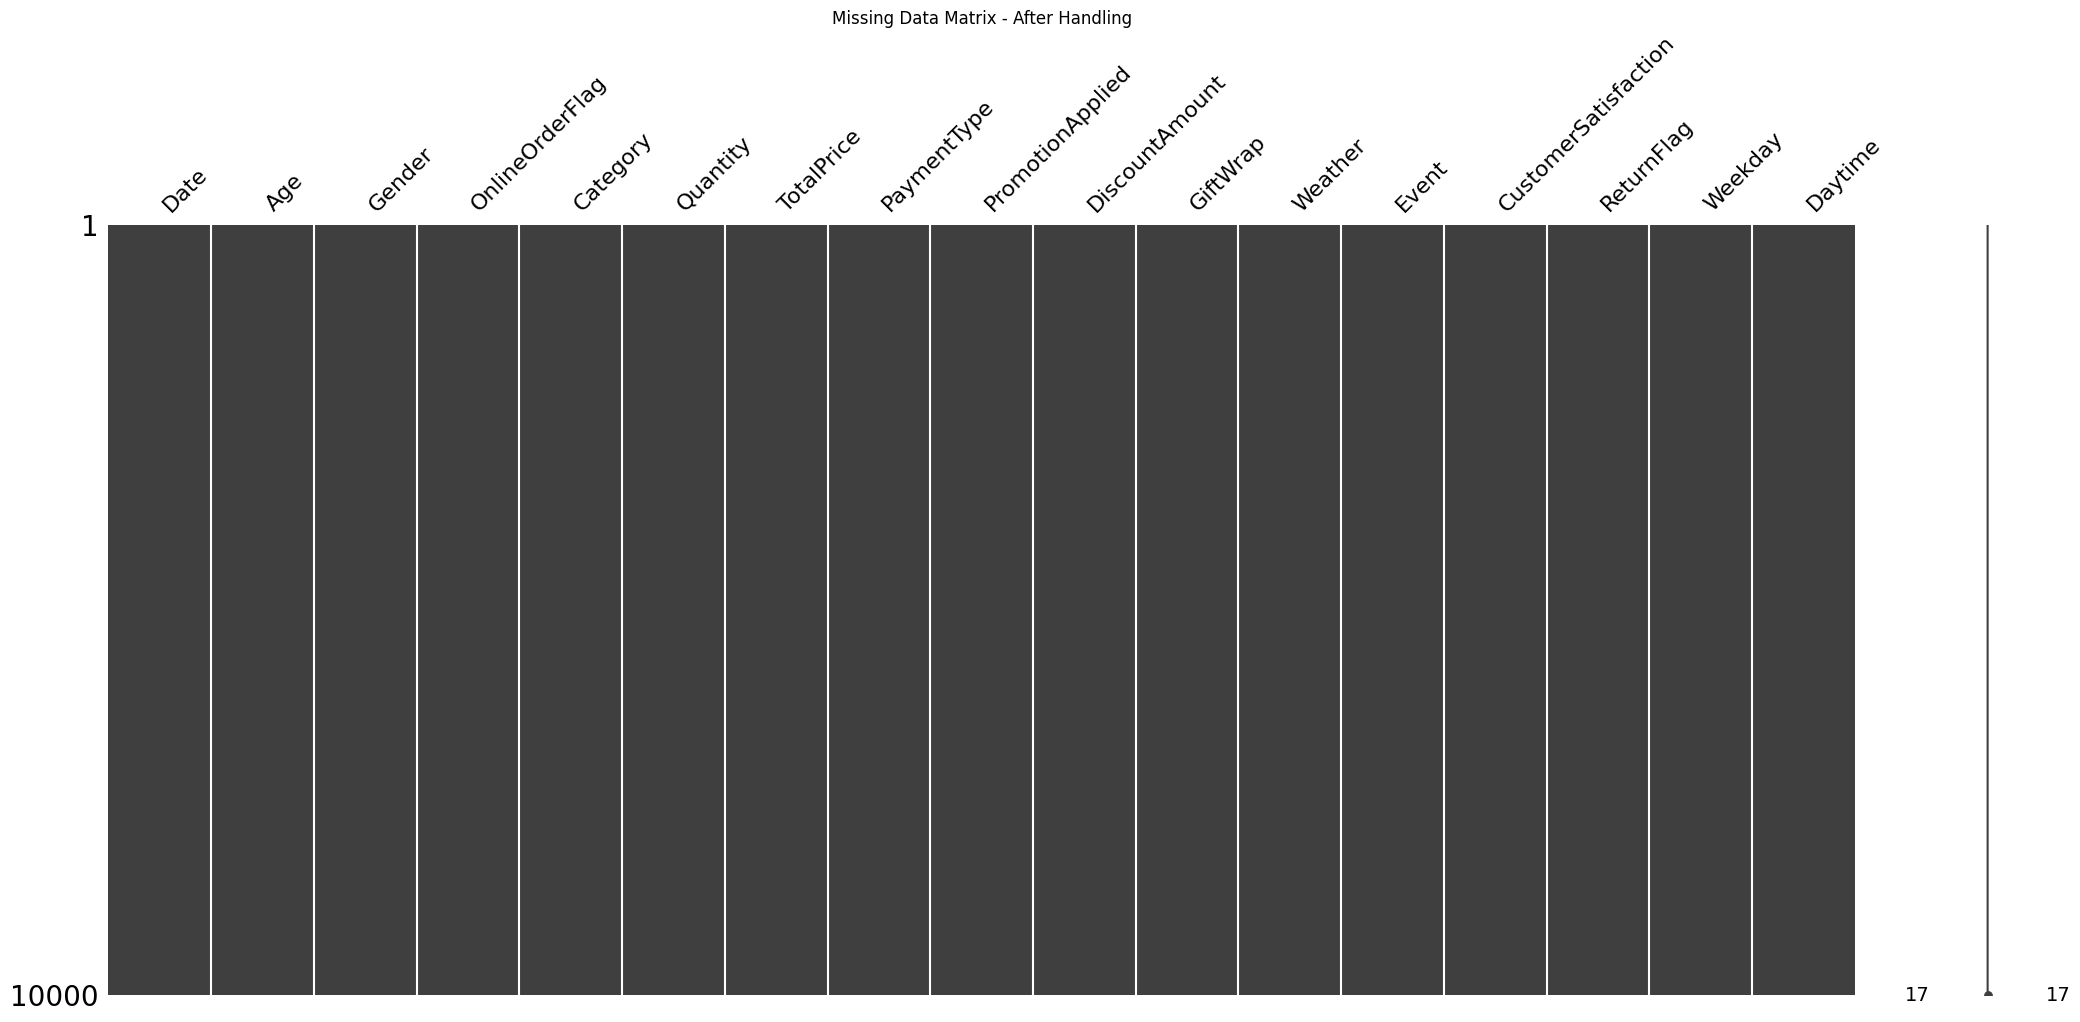

In [ ]:
# Ensure 'ShippingMethod' and 'DeliveryTime' are dropped
columns_to_drop = ['StoreID', 'ShippingMethod', 'DeliveryTime', 'TransactionID', 'CustomerID', 'ProductID', 'ProductName','UnitPrice', 'Location']
holiday_sales.drop(columns=[col for col in columns_to_drop if col in holiday_sales.columns], inplace=True, errors='ignore')
print(f"Remaining Columns:\n{holiday_sales.columns}")

# Visualize missing data after handling
msno.matrix(holiday_sales)
plt.title("Missing Data Matrix - After Handling")
plt.show()

# Drop rows where Gender is 'Other'
holiday_sales = holiday_sales[holiday_sales['Gender'] != 'Other']

**Exploratory Data Analysis**

Exploratory Data Analysis helps us uncover key patterns and trends in the dataset to guide subsequent modeling and decision-making.

**Event Distribution Analysis**
We began by visualizing the distribution of shopping events (Black Friday, Christmas Market, and Normal Days) to understand their relative frequencies.

**Who’s Shopping?**
To understand customer behavior, we analyzed demographic factors such as age and gender. These analyses revealed patterns that highlight the characteristics of different shopper groups during Black Friday, Christmas, and Normal Days.



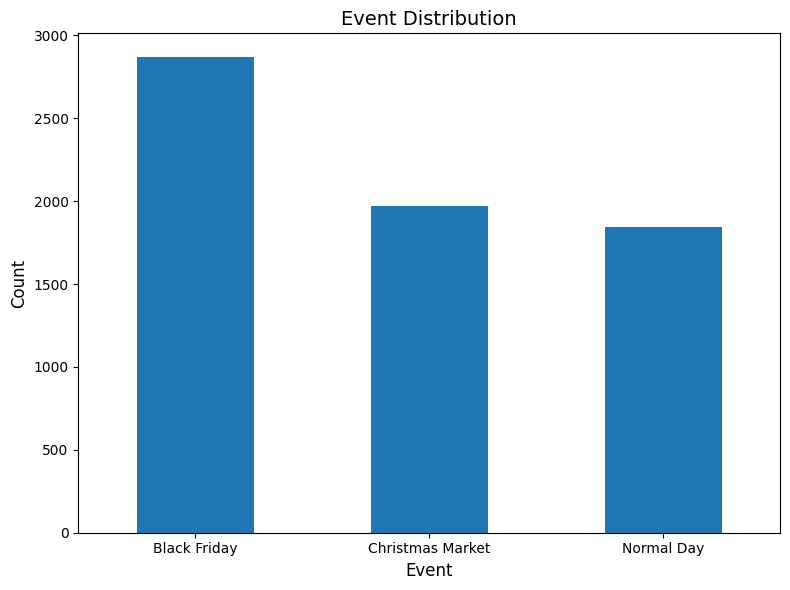

In [ ]:
import pandas as pd

# Count the occurrences in the "Event" column
event_counts = holiday_sales["Event"].value_counts()

# Create the bar chart
plt.figure(figsize=(8, 6))
event_counts.plot(kind="bar")
plt.title("Event Distribution", fontsize=14)
plt.xlabel("Event", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


The bar chart shows that Black Friday events have the highest participation, significantly outnumbering purchases during Christmas Market and Normal Days. This indicates Black Friday's dominance in driving customer activity compared to other shopping periods.

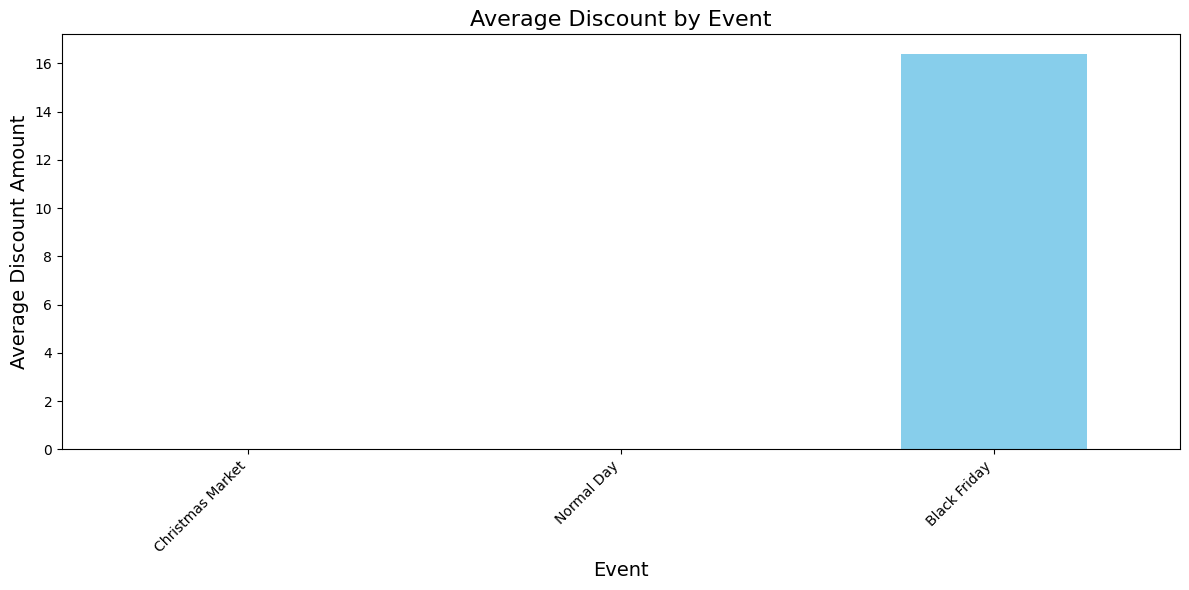

In [ ]:
event_discount = holiday_sales.groupby('Event')['DiscountAmount'].mean()
plt.figure(figsize=(12, 6))
event_discount.sort_values().plot(kind='bar', color='skyblue')
plt.title('Average Discount by Event', fontsize=16)
plt.xlabel('Event', fontsize=14)
plt.ylabel('Average Discount Amount', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.gcf().set_facecolor('none')
plt.show()


The chart illustrates that Black Friday had the only discount amount, indicating its role as a significant sales driver by attracting customers through aggressive promotional pricing. This highlights the importance of discount strategies in maximizing sales during this key shopping event.

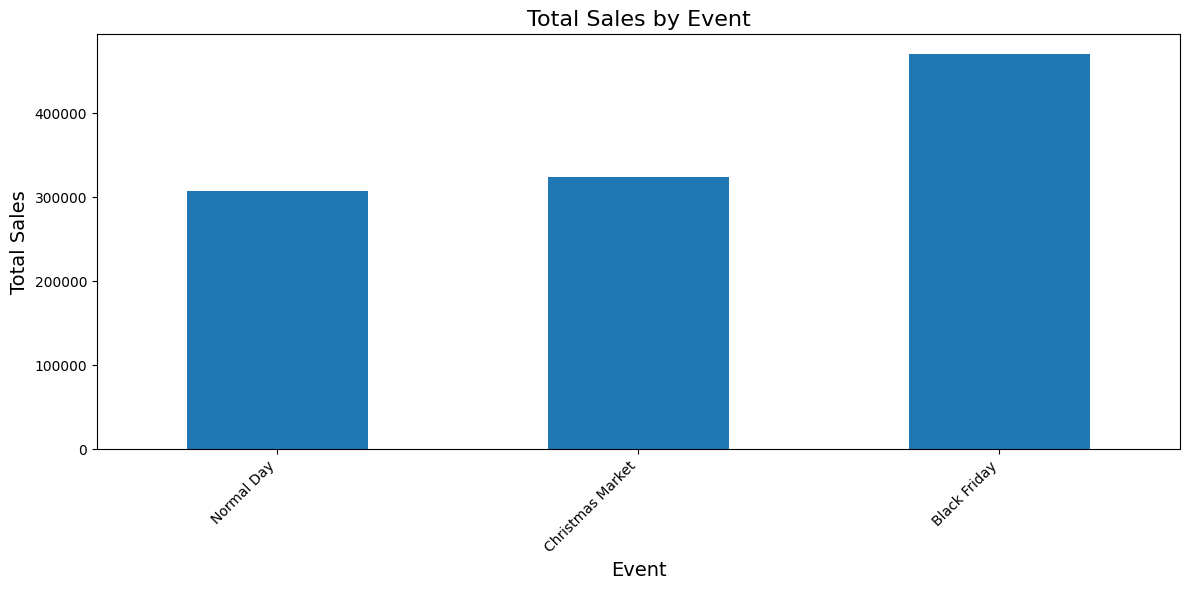

In [ ]:
event_total_price = holiday_sales.groupby('Event')['TotalPrice'].sum()
plt.figure(figsize=(12, 6), facecolor='none')
event_total_price.sort_values().plot(kind='bar')
plt.title('Total Sales by Event', fontsize=16)
plt.xlabel('Event', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The chart illustrates the total sales across different events. Black Friday generated the highest total sales, significantly surpassing both Christmas Market and Normal Day. This indicates that Black Friday is a key driver of revenue, highlighting its importance for sales-focused strategies compared to other events.

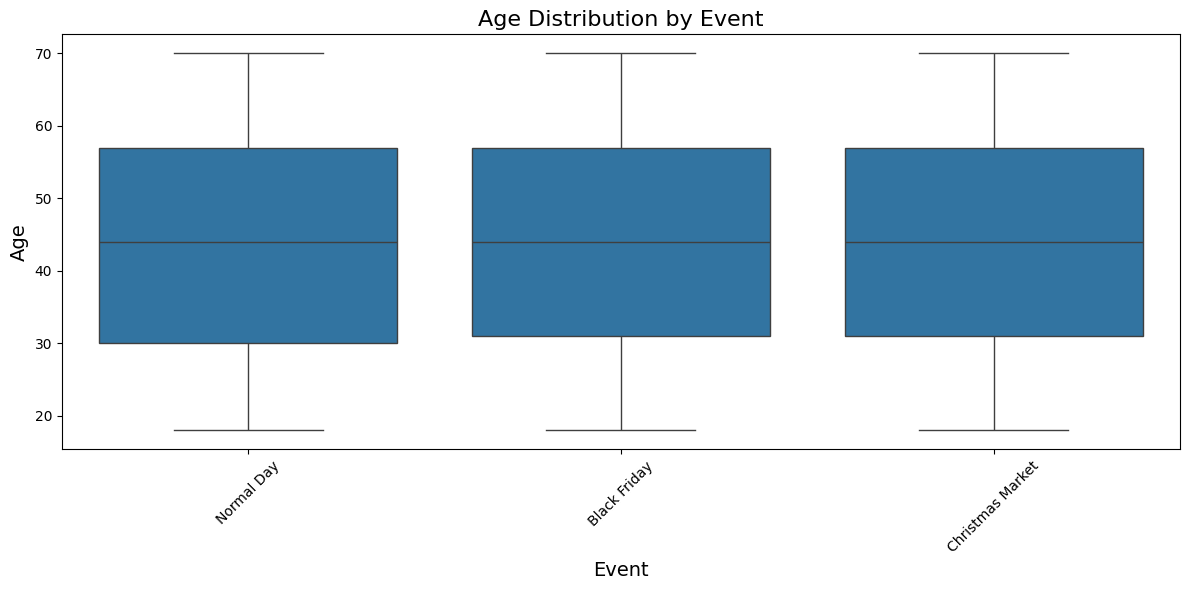

In [ ]:
plt.figure(figsize=(12, 6), facecolor='none')
sns.boxplot(x='Event', y='Age', data=holiday_sales)
plt.title('Age Distribution by Event', fontsize=16)
plt.xlabel('Event', fontsize=14)
plt.ylabel('Age', fontsize=14)
plt.xticks(rotation=45)
ax = plt.gca()
ax.set_facecolor('none')
plt.tight_layout()
plt.show()

The age distributions are very similar across all events, with a median age around 40-45 and a range from 20 to 70.

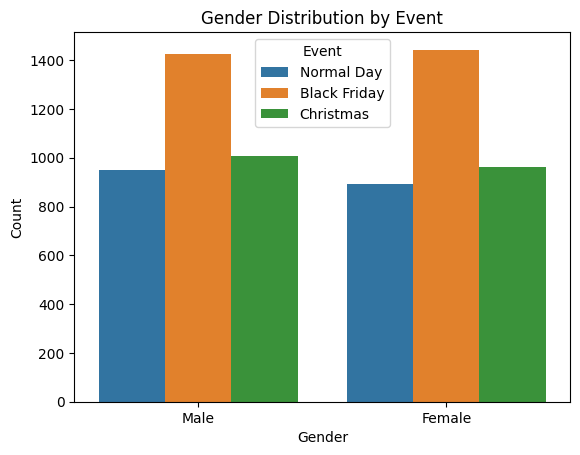

In [ ]:
# Countplot for Gender distribution by event
sns.countplot(x='Gender', hue='Event', data=holiday_sales)
plt.title('Gender Distribution by Event')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Event', labels=['Normal Day', 'Black Friday', 'Christmas'])
plt.show()


This bar chart shows that "Black Friday" consistently has the highest participation for both genders, while "Normal Day" and "Christmas" have similar counts for each gender.

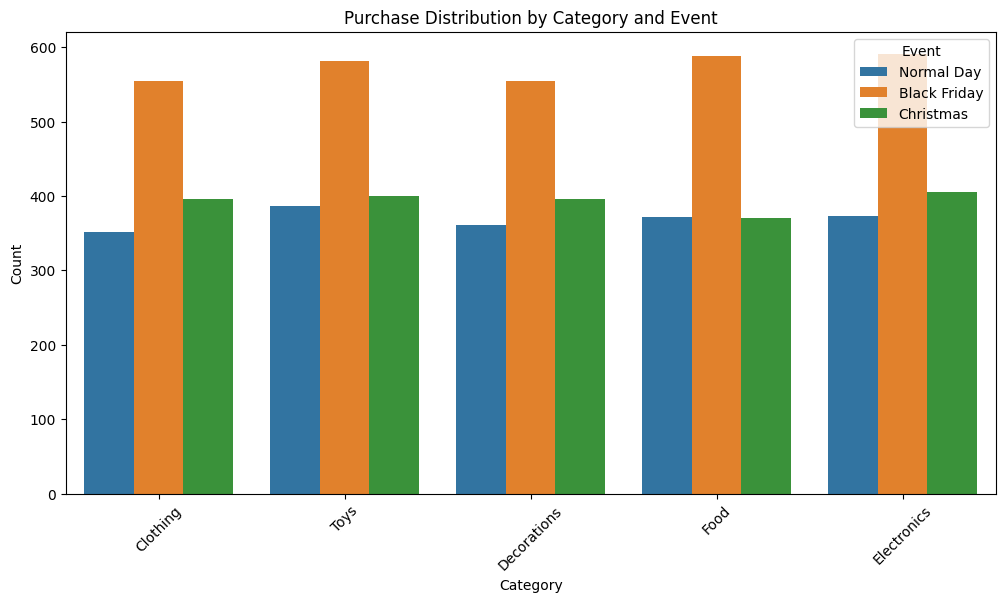

In [ ]:
# Countplot for Category distribution by event
plt.figure(figsize=(12, 6))
sns.countplot(x='Category', hue='Event', data=holiday_sales)
plt.title('Purchase Distribution by Category and Event')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Event', labels=['Normal Day', 'Black Friday', 'Christmas'])
plt.show()


The chart displays the distribution of purchases across five product categories (Clothing, Toys, Decorations, Food, Electronics) during three events: Black Friday, Christmas Market, and Normal Day.

**Black Friday** consistently shows the highest purchase counts across all categories, indicating a significant increase in consumer activity during this event compared to others.
**Christmas Market** follows Black Friday, with slightly lower purchase counts across categories, suggesting targeted consumer interest, particularly in Toys and Decorations, which are associated with the holiday season.
**Normal Day** has the lowest purchase counts across all categories, reflecting steady but lower consumer activity outside special events.
This pattern underscores the dominance of Black Friday for sales across all product categories and highlights opportunities for focused marketing during Christmas in specific categories like Toys and Decorations.

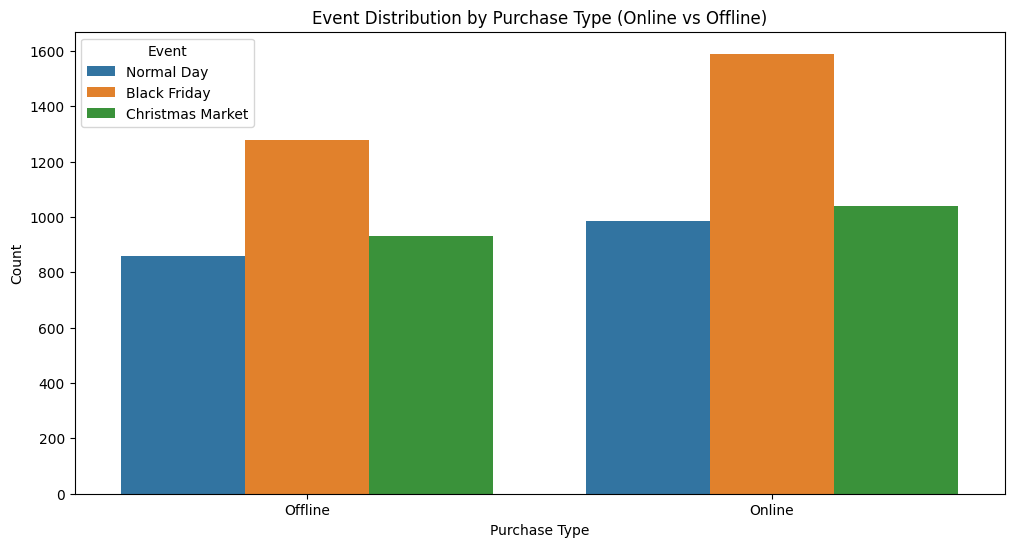

In [ ]:
# Countplot for Purchase Type distribution by Event
plt.figure(figsize=(12, 6))
sns.countplot(x='OnlineOrderFlag', hue='Event', data=holiday_sales)
plt.title('Event Distribution by Purchase Type (Online vs Offline)')
plt.xlabel('Purchase Type')
plt.ylabel('Count')
plt.xticks([0, 1], labels=['Offline', 'Online'])
plt.legend(title='Event')
plt.show()

The chart illustrates the distribution of purchases by event type (Normal Day, Black Friday, Christmas Market) across two purchase modes: offline and online.

**Black Friday** demonstrates the highest purchase counts in both offline and online channels, with online purchases slightly surpassing offline ones. This reflects Black Friday's dominance in driving both traditional and digital sales.
**Christmas Market** shows a balanced distribution between offline and online purchases, indicating steady consumer interest in both channels during the holiday season.
**Normal Day** has the lowest purchase counts in both offline and online modes, with comparable levels in each channel, highlighting a baseline consumer activity outside special events.
These insights suggest that Black Friday campaigns should prioritize both online and offline channels, while Christmas Market campaigns can benefit from equal emphasis on both modes.

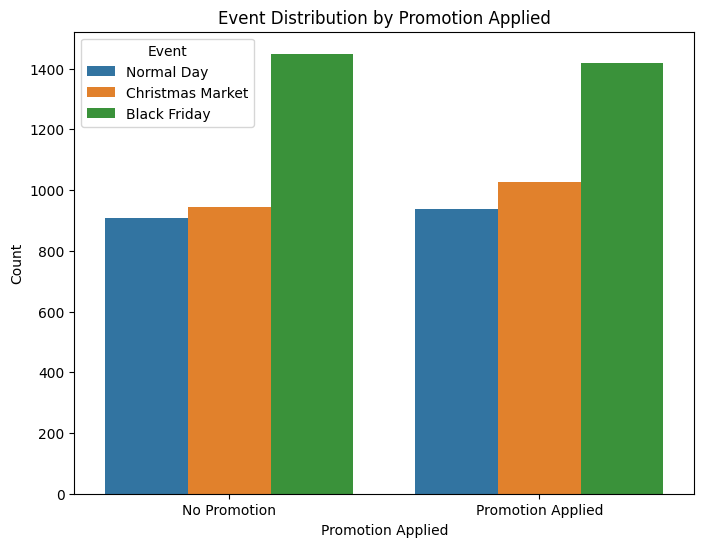

In [ ]:
# Countplot for PromotionApplied by Event
plt.figure(figsize=(8, 6))
sns.countplot(x='PromotionApplied', hue='Event', data=holiday_sales)
plt.title('Event Distribution by Promotion Applied')
plt.xlabel('Promotion Applied')
plt.ylabel('Count')
plt.xticks([0, 1], labels=['No Promotion', 'Promotion Applied'])
plt.legend(title='Event')
plt.show()


The chart shows the distribution of purchases across different events (Normal Day, Christmas Market, Black Friday) based on whether a promotion was applied.

**Black Friday** has the highest number of purchases both with and without promotions, emphasizing the strong consumer interest in this event regardless of promotional incentives.
**Christmas Market** purchases are higher when promotions are applied compared to no promotions, indicating that consumers during this event are more responsive to discounts and offers.
**Normal Day** purchases show a similar distribution across both categories, suggesting that promotions have a relatively limited effect on driving purchases outside special events.
These patterns suggest that promotions play a more significant role during Christmas Market, while Black Friday generates high demand with or without promotions. For Normal Days, other strategies beyond promotions might be needed to boost sales.

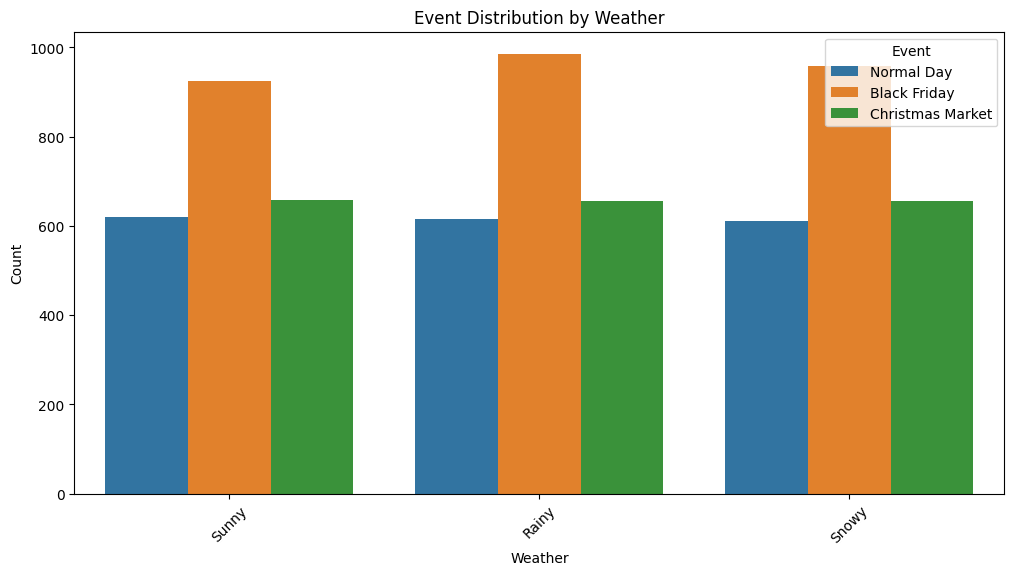

In [ ]:
# Countplot for Weather by Event
plt.figure(figsize=(12, 6))
sns.countplot(x='Weather', hue='Event', data=holiday_sales)
plt.title('Event Distribution by Weather')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.legend(title='Event')
plt.show()



This bar chart shows the distribution of events ("Normal Day," "Black Friday," and "Christmas Market") across different weather conditions ("Sunny," "Rainy," "Snowy"). It indicates that "Black Friday" consistently has the highest number of purchases regardless of the weather, while "Normal Day" and "Christmas Market" have similar counts in each condition.

# Step 2: Data Preprocessing and Model Training

To make the data easier to work with, we removed columns that didn’t directly contribute to our analysis, such as StoreID, ShippingMethod, and ProductName. These columns, while interesting, wouldn’t help us predict sales events.

We then addressed missing values in the Event column, replacing them with 'None'. This ensured our target variable was complete and ready for analysis.

We transformed the Date column into a treasure chest of new information:

Extracted the day of the week.
Marked weekends with a flag to highlight Saturdays and Sundays.
Identified the month, which helped us flag the holiday season (November and December).

Next, we separated the dataset into:

Features (X): All columns except the Event.
Target (y): The Event column, which represented the type of sales event.
To help our models understand the target variable, we used Label Encoding to convert the event names into numerical values.

We then categorized the features into two groups:

Numerical Features like Age, Quantity, and TotalPrice.
Categorical Features like Gender, PaymentType, and Weekday.

For each type of feature, we built a custom preprocessing pipeline:

Numerical Features: Missing values were filled using the median.
Categorical Features: Missing values were filled with the most frequent category, and the data was one-hot encoded to make it machine-readable.
We combined these pipelines into a ColumnTransformer, ensuring that all features were preprocessed consistently.

We created pipelines for four machine learning models, each paired with the preprocessing steps.

To evaluate our models, we split the dataset into:
70% training data, where the models would learn.
30% testing data, where the models would face unseen examples to test their performance.
We used stratification to make sure the class distribution of Event was the same in both sets. A random seed (random_state=42) ensured the process could be repeated exactly the same way.


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

columns_to_drop = ['StoreID', 'ShippingMethod', 'DeliveryTime', 'TransactionID', 'CustomerID', 'ProductID', 'ProductName', 'Weather']
holiday_sales.drop(columns=columns_to_drop, inplace=True, errors='ignore')
holiday_sales['Event'].fillna('None', inplace=True)

holiday_sales['Date'] = pd.to_datetime(holiday_sales['Date'], format='%m/%d/%y', errors='coerce')
holiday_sales['Weekday'] = holiday_sales['Date'].dt.day_name()
holiday_sales['Is_Weekend'] = holiday_sales['Weekday'].isin(['Saturday', 'Sunday']).astype(int)
holiday_sales['Month'] = holiday_sales['Date'].dt.month
holiday_sales['Is_Holiday_Season'] = holiday_sales['Month'].isin([11, 12]).astype(int)

X = holiday_sales.drop(columns=['Event'])
y = holiday_sales['Event']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
numerical_features = ['Age', 'Quantity', 'TotalPrice', 'DiscountAmount', 'CustomerSatisfaction']
categorical_features = ['Gender', 'Category', 'PaymentType', 'GiftWrap', 'Weekday']
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])


pipelines = {
    'Logistic Regression': logistic_pipeline,
    'Decision Tree': decision_tree_pipeline,
    'Random Forest': random_forest_pipeline,
}

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

<ipython-input-219-e0a25c1e222d>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  holiday_sales['Event'].fillna('None', inplace=True)


In [ ]:
for index, label in enumerate(label_encoder.classes_):
    print(f"{index}: {label}")

0: Black Friday
1: Christmas Market
2: Normal Day


This shows how the labels for the target variable (event categories) are encoded into numeric values using a label encoder. The mapping is as follows: 0: Black Friday
1: Christmas Market
2: Normal Day
This encoding is used to convert categorical labels into numerical representations that can be processed by machine learning models.

# Step 3: Model Training and Evaluation

We selected Logistic Regression, Decision Tree, and Random Forest to suit our data and prediction goals. Logistic Regression provides a simple baseline, Decision Tree captures non-linear relationships in our mixed data, and Random Forest enhances accuracy by reducing overfitting through ensemble learning. Together, these models balance interpretability and performance for our purchase prediction task.

We did not choose other models like SVM or KNN because they are less suitable for our dataset, which requires a balance between interpretability, computational efficiency, and performance. Given the structured nature of our data and our predictive goals, models we chose were more appropriate as they align well with the dataset's characteristics and offer meaningful insights into feature importance and decision-making processes.

## Logistic Regression


In [ ]:
logistic_pipeline.fit(X_train, y_train)
y_pred_logistic = logistic_pipeline.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("\nClassification Report:\n", classification_report(y_test, y_pred_logistic))

Logistic Regression Accuracy: 0.7037406483790524

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       861
           1       0.50      0.66      0.57       591
           2       0.44      0.29      0.35       553

    accuracy                           0.70      2005
   macro avg       0.65      0.65      0.64      2005
weighted avg       0.70      0.70      0.69      2005



Logistic Regression achieves an accuracy of 70.37%. The model performs well for class 0 but struggles with lower precision and recall for classes 1 and 2.

## Decision Tree

In [ ]:
decision_tree_pipeline.fit(X_train, y_train)
y_pred_tree = decision_tree_pipeline.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tree))

Decision Tree Accuracy: 0.7172069825436409

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       861
           1       0.52      0.51      0.52       591
           2       0.49      0.49      0.49       553

    accuracy                           0.72      2005
   macro avg       0.67      0.67      0.67      2005
weighted avg       0.72      0.72      0.72      2005



Decision Tree achieves an accuracy of 71.72%. While the model performs perfectly for class 0, it shows moderate precision and recall for classes 1 and 2, indicating room for improvement in handling these classes.

## Random Forest

In [ ]:
random_forest_pipeline.fit(X_train, y_train)
y_pred_rf = random_forest_pipeline.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7077306733167082

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       861
           1       0.50      0.54      0.52       591
           2       0.47      0.43      0.45       553

    accuracy                           0.71      2005
   macro avg       0.66      0.66      0.66      2005
weighted avg       0.71      0.71      0.71      2005



Random Forest model achieves an accuracy of 70.77%. The model performs exceptionally well for class 0 but has lower precision and recall for classes 1 and 2, indicating challenges in effectively classifying these categories.

# Step 4: Cross Validation


The Cross-Validation process was applied to both the Decision Tree and Random Forest models to assess their reliability and robustness. This method evaluates model performance by splitting the dataset into multiple folds, ensuring that the results are not dependent on a single train-test split. By doing so, we gain insights into how consistently each model performs across different data splits, providing a comprehensive understanding of their generalizability to unseen data.

## DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

decision_tree_cv_scores = cross_val_score(
    decision_tree_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy'
)
print(f"Decision Tree Cross-Validation Accuracy: {decision_tree_cv_scores.mean():.2f} (+/- {decision_tree_cv_scores.std():.2f})")

Decision Tree Cross-Validation Accuracy: 0.71 (+/- 0.01)


The Decision Tree model achieved a consistent cross-validation accuracy of 71% with minimal variation (±1%). This indicates consistent performance across different training and testing splits.

## Randome Forest

In [ ]:
from sklearn.model_selection import cross_val_score
random_forest_cv_scores = cross_val_score(random_forest_pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f"Random Forest Cross-Validation Accuracy: {random_forest_cv_scores.mean():.2f} (+/- {random_forest_cv_scores.std():.2f})")

Random Forest Cross-Validation Accuracy: 0.71 (+/- 0.01)


The Random Forest model achieved a cross-validation accuracy of 71% with a minimal standard deviation of ±1%, showing consistency across folds.

# Step 5: Hyperparameter Tuning for Decision Tree and Random Forest


Then, we performed hyperparameter tuning for the Decision Tree and Random Forest models to optimize their performance. Using GridSearchCV, we tested different combinations of parameters, including split criteria, maximum depth, and minimum sample requirements for splits and leaf nodes.

## Deicision Tree

In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

param_grid_dt = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 5, 10, 20, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5, 10]
}

grid_search_dt = GridSearchCV(decision_tree_pipeline, param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)

best_dt_model = grid_search_dt.best_estimator_
y_pred_best_dt = best_dt_model.predict(X_test)
print("Optimized Decision Tree Accuracy:", accuracy_score(y_test, y_pred_best_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_dt))

Best parameters for Decision Tree: {'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
Optimized Decision Tree Accuracy: 0.7226932668329177

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       861
           1       0.53      0.60      0.56       591
           2       0.50      0.42      0.45       553

    accuracy                           0.72      2005
   macro avg       0.67      0.67      0.67      2005
weighted avg       0.72      0.72      0.72      2005




The best parameters for the Decision Tree were gini as the criterion, a maximum depth of 20, and minimum samples of 2 for splits and leaves. The optimized model achieved an accuracy of 72.27%. This is a slight improvement over the baseline. Hyperparameter tuning improved model predictions and overall performance.

## Random Forest

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(
    estimator=random_forest_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
print("Optimized Random Forest Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_rf))

Best parameters for Random Forest: {'classifier__bootstrap': True, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Optimized Random Forest Accuracy: 0.7112219451371571

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       861
           1       0.51      0.71      0.59       591
           2       0.46      0.27      0.34       553

    accuracy                           0.71      2005
   macro avg       0.66      0.66      0.64      2005
weighted avg       0.71      0.71      0.70      2005



The optimized Random Forest model delivered an accuracy of 71.12% on the test set. A detailed classification report indicated balanced precision, recall, and F1-scores for various classes, with class "0" achieving a perfect score across all metrics. However, performance for other classes showed room for improvement, reflecting challenges in correctly predicting minority classes.


# Step 6: Model Evaluation before Feature Selection(Decision Tree)

Before applying feature selection, we evaluated the Decision Tree model to understand its baseline performance. Using cost-complexity pruning, we identified the optimal ccp_alpha value to balance the model's complexity and accuracy.

Best ccp_alpha: 0.000329242106124976
Test Accuracy at Best Alpha: 0.74
Train Accuracy at Best Alpha: 0.90

Final Model Accuracy: 0.7301745635910224

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       861
           1       0.54      0.53      0.54       591
           2       0.51      0.52      0.51       553

    accuracy                           0.73      2005
   macro avg       0.68      0.68      0.68      2005
weighted avg       0.73      0.73      0.73      2005



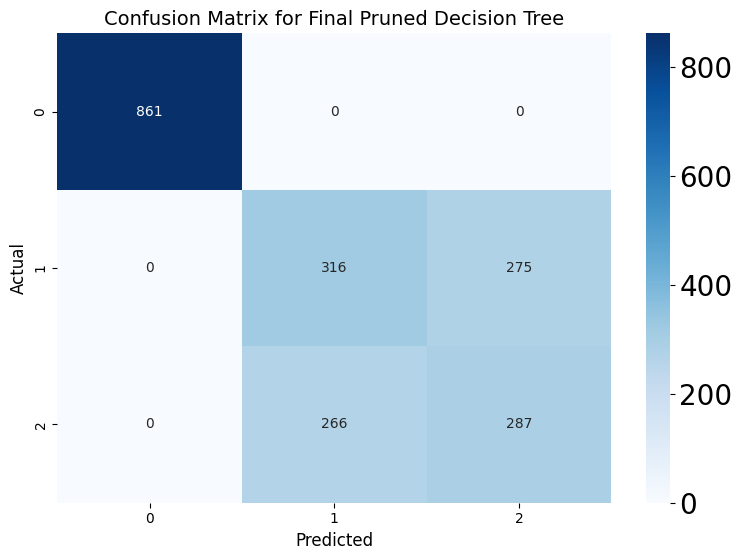

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn import set_config
set_config(display='diagram')
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
    ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_encoder', OneHotEncoder(sparse_output=False))
    ])

prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline, make_column_selector(dtype_include='category'))
], verbose_feature_names_out=False)

prep_pipeline.set_output(transform='pandas')

X_train_prepd = prep_pipeline.fit_transform(X_train)
X_test_prepd = prep_pipeline.transform(X_test)

clf_full = DecisionTreeClassifier(random_state=0)
path = clf_full.cost_complexity_pruning_path(X_train_prepd, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf_i = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_i.fit(X_train_prepd, y_train)
    clfs.append(clf_i)

node_counts = [clf_i.tree_.node_count for clf_i in clfs]
depth = [clf_i.tree_.max_depth for clf_i in clfs]

train_scores = [clf_i.score(X_train_prepd, y_train) for clf_i in clfs]
test_scores = [clf_i.score(X_test_prepd, y_test) for clf_i in clfs]

best_alpha_index = np.argmax(test_scores)
best_alpha = ccp_alphas[best_alpha_index]
print(f"Best ccp_alpha: {best_alpha}")
print(f"Test Accuracy at Best Alpha: {test_scores[best_alpha_index]:.2f}")
print(f"Train Accuracy at Best Alpha: {train_scores[best_alpha_index]:.2f}")

final_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
final_clf.fit(X_train_prepd, y_train)

y_pred = final_clf.predict(X_test_prepd)

accuracy = accuracy_score(y_test, y_pred)
print("\nFinal Model Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test),
            annot_kws={"size": 10})
plt.title("Confusion Matrix for Final Pruned Decision Tree", fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

The evaluation of the Decision Tree model before feature selection provided key insights into its baseline performance. Using cost-complexity pruning, we identified the optimal ccp_alpha value, which achieved a test accuracy of 73.01% and a training accuracy of 90%. The model demonstrated excellent performance for Black Friday, with perfect precision and recall, but faced challenges in accurately classifying Christmas and Normal Day. The confusion matrix further highlighted misclassifications between these categories, indicating potential areas for improvement. This evaluation underscores the importance of refining features and exploring advanced techniques to enhance the model's predictive performance for the more challenging classes.

# Step 7: Feature Importance Analysis

To identify the most predictive features and enhance the model’s performance, I utilized two different feature selection methods. The first approach involved DecisionTreeClassifier feature importance analysis, which evaluates each feature’s contribution to the decision splits within the tree.

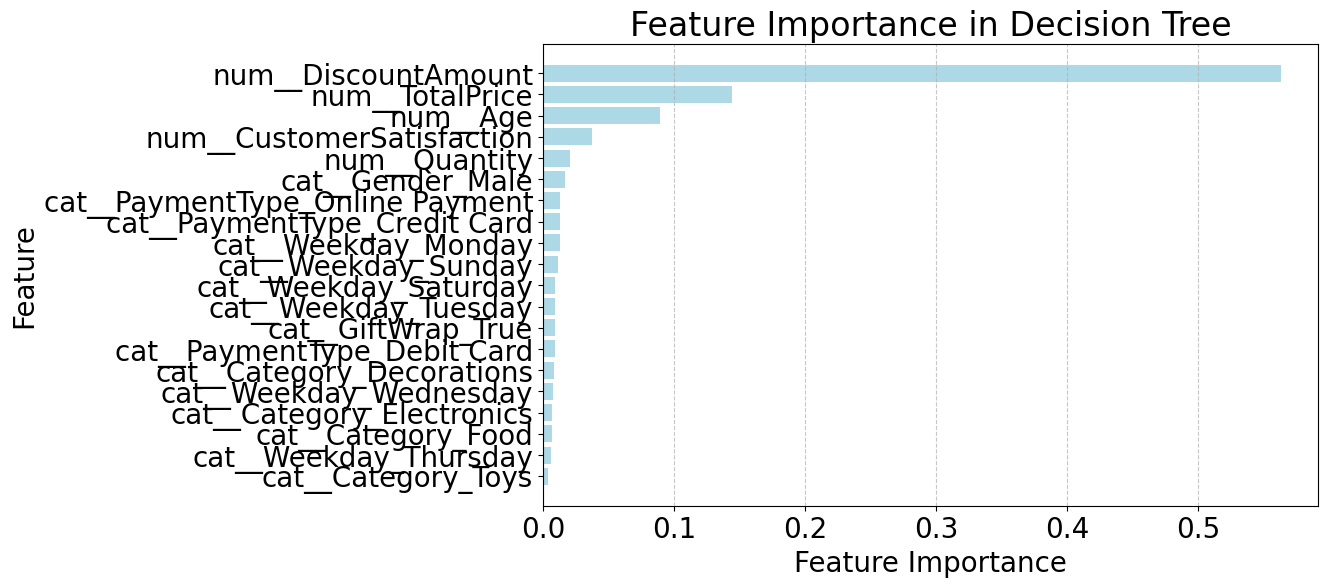

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

decision_tree_model.fit(X_train, y_train)

importances = decision_tree_model.named_steps['classifier'].feature_importances_
feature_names = preprocessor.get_feature_names_out()

sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances, color='lightblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree')

plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

This bar chart visualizes the feature importance in the Decision Tree model. The most significant factors influencing holiday sales predictions are:

**- Discount Amount:** The strongest predictor, highlighting the critical role of discounts in driving purchases during shopping events.

**- Total Price:** Indicates the overall spending capacity of customers, which plays a significant role in predicting shopping behavior.

**- Age:** Demonstrates the importance of customer demographics in influencing purchase patterns.

Other features, such as Customer Satisfaction, Quantity Purchased, and payment types, show comparatively lower importance, suggesting their more limited influence on the model’s predictions. This analysis provides actionable insights for designing targeted promotions and customer-specific marketing strategies.

# Step 8: Sequential Feature Selection

Next, I applied Sequential Feature Selector (SFS) with DecisionTreeClassifier to systematically identify an optimal subset of features. This method evaluates combinations of features using cross-validation (CV=5) and selects the best-performing subset.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline

decision_tree = DecisionTreeClassifier()

sfs = SequentialFeatureSelector(
    decision_tree,
    k_features="best",
    forward=True,
    scoring='accuracy',
    cv=5
)

sfs_pipe = Pipeline([
    ('prep', preprocessor),
    ('select', sfs),
    ('model', DecisionTreeClassifier())
])


sfs_pipe.fit(X_train, y_train)
selected_features_sfs = sfs.k_feature_names_
selected_feature_names = X_train.columns[list(map(int, selected_features_sfs))]
print("Selected Features (names):", selected_feature_names)

Selected Features (names): Index(['Age', 'OnlineOrderFlag', 'PaymentType', 'GiftWrap', 'Month',
       'Is_Holiday_Season'],
      dtype='object')


The finalized pipeline combined preprocessing, feature selection, and modeling, producing an optimized subset of features: ['Age', 'OnlineOrderFlag', 'PaymentType', 'GiftWrap', 'Month', 'Is_Holiday_Season']. This selection reflects the core factors influencing sales outcomes and allows the model to maintain predictive accuracy while reducing computational complexity. This refined feature set positions the model for better generalization and interpretability in subsequent evaluations.

# Step 9: Final Model Evaluation

As we conclude our analysis and modeling process, we evaluated the final model's performance on the test dataset to confirm its reliability and predictive capabilities. After careful feature selection and optimization, we built a model designed to balance accuracy and generalizability.



In [ ]:
from sklearn.preprocessing import LabelEncoder
selected_features = ['Age', 'TotalPrice', 'DiscountAmount']
X_train_selected = X_train[selected_features]
X_test_selected= X_test[selected_features]

We utilized a Decision Tree model focusing on three key classes: Class 0 (Black Friday), Class 1 (Christmas), and Class 2 (Normal Day). By limiting the tree depth to 3 for interpretability, we identified the most influential features driving predictions.

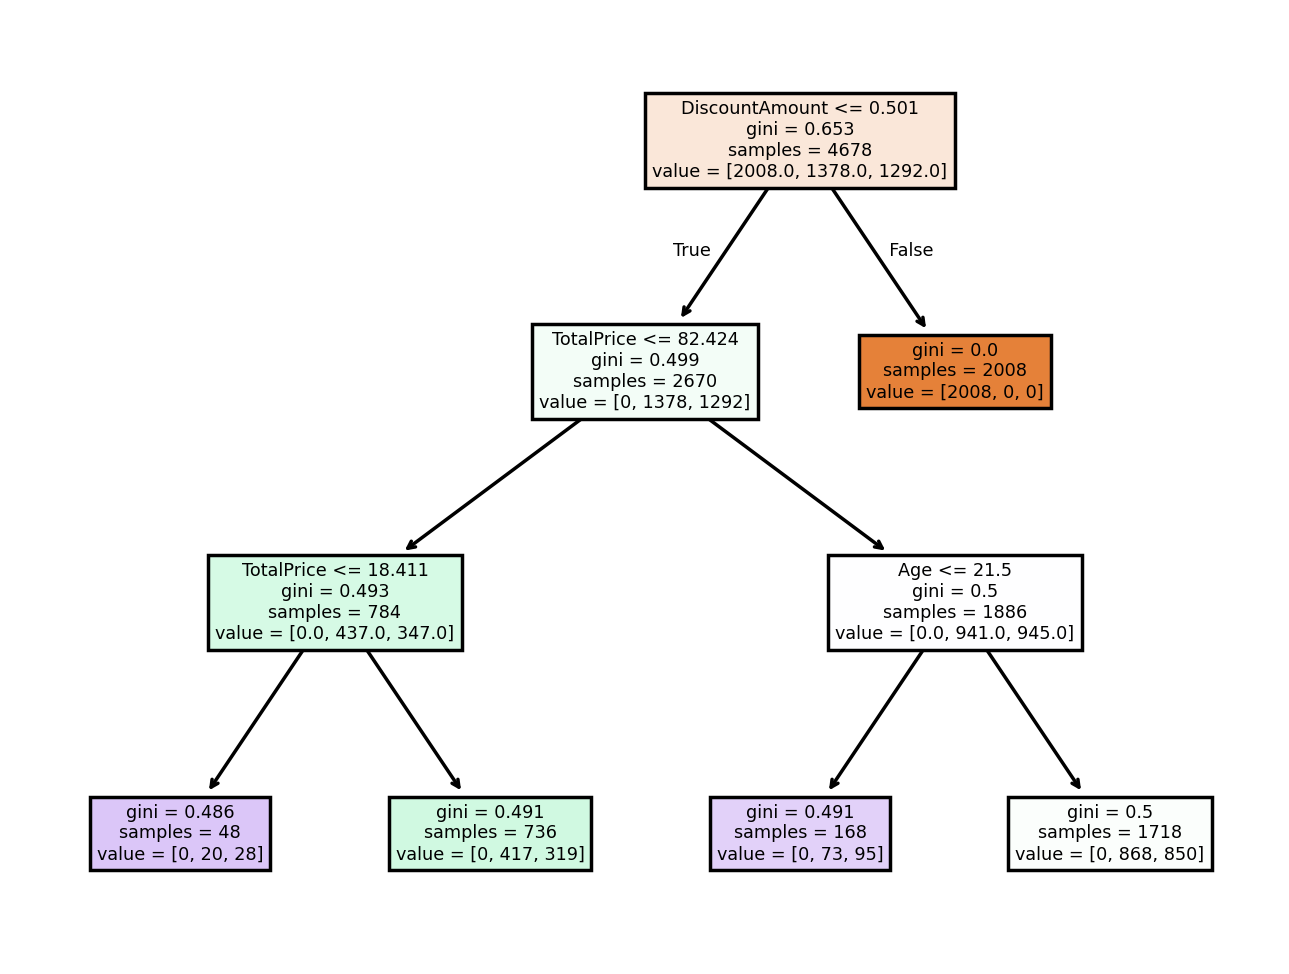

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.tree import plot_tree
from sklearn import set_config

set_config(display='diagram')
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
    ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_encoder', OneHotEncoder(sparse_output=False))
    ])
prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline, make_column_selector(dtype_include='category'))
], verbose_feature_names_out=False)

prep_pipeline.set_output(transform='pandas')

X_train_prepd = prep_pipeline.fit_transform(X_train_selected)
X_test_prepd = prep_pipeline.transform(X_test_selected)

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train_prepd, y_train)
plt.figure(dpi=250)
plot_tree(clf, filled=True, feature_names=list(X_train_selected.columns));

This simplified tree structure highlights how promotional discounts, overall spending, and demographic factors like age contribute to predicting shopping events. It underscores the distinct characteristics of Black Friday and Christmas, helping businesses better understand their customer behaviors during these critical periods.

Then, we utilized cost-complexity pruning to refine the Decision Tree model by analyzing alpha values.

There are 373 alpha values.


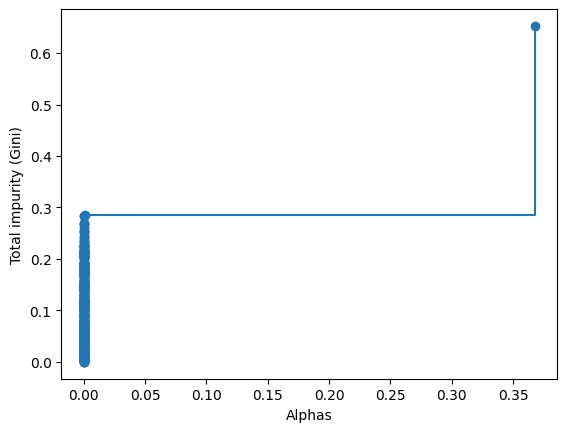

In [ ]:
clf_full = DecisionTreeClassifier()
path = clf_full.cost_complexity_pruning_path(X_train_prepd, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
plt.plot(ccp_alphas, impurities, marker='o', drawstyle='steps-post')
plt.xlabel('Alphas'); plt.ylabel('Total impurity (Gini)');

print(f'There are {ccp_alphas.shape[0]} alpha values.')

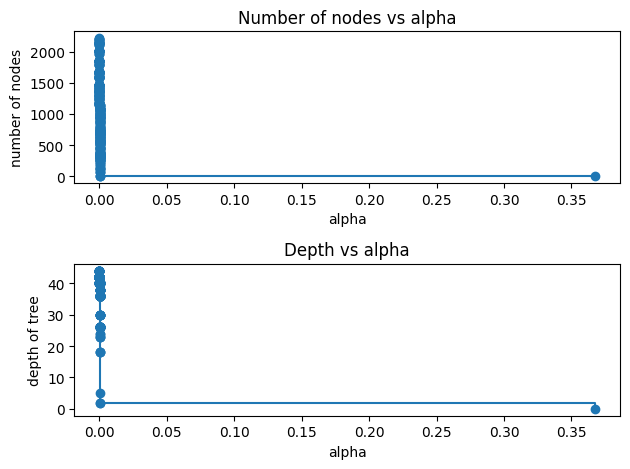

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf_i = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_i.fit(X_train_prepd, y_train)
    clfs.append(clf_i)

node_counts = [clf_i.tree_.node_count for clf_i in clfs]
depth = [clf_i.tree_.max_depth for clf_i in clfs]

fig, ax = plt.subplots(2, 1, dpi=100)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()


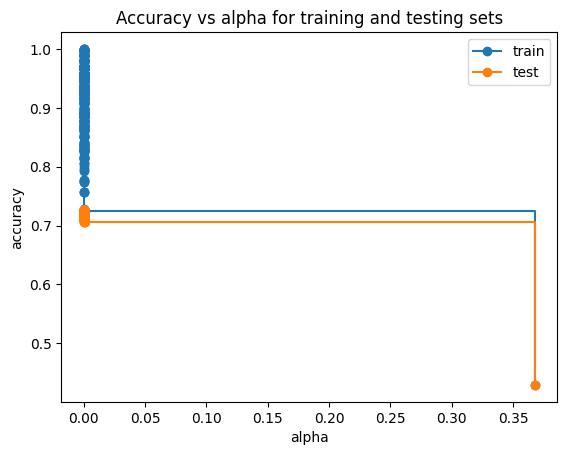

In [ ]:
train_scores = [clf_i.score(X_train_prepd, y_train) for clf_i in clfs]
test_scores = [clf_i.score(X_test_prepd, y_test) for clf_i in clfs]

fig, ax = plt.subplots(dpi=100)
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ccp_alpha': ccp_alphas}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_prepd, y_train)

grid_cv_res = pd.DataFrame(grid_search.cv_results_)
grid_cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
display(grid_cv_res.filter(regex = '(^param_|mean_test_score)', axis=1).head())
best_tree = grid_search.best_estimator_
print(f'The total number of nodes is {best_tree.tree_.node_count} and the max depth is {best_tree.tree_.max_depth}.')


,param_ccp_alpha,mean_test_score
360,0.000436,0.724668
359,0.000435,0.724454
358,0.000431,0.722957
357,0.000429,0.722315
356,0.000421,0.721674


The total number of nodes is 165 and the max depth is 26.


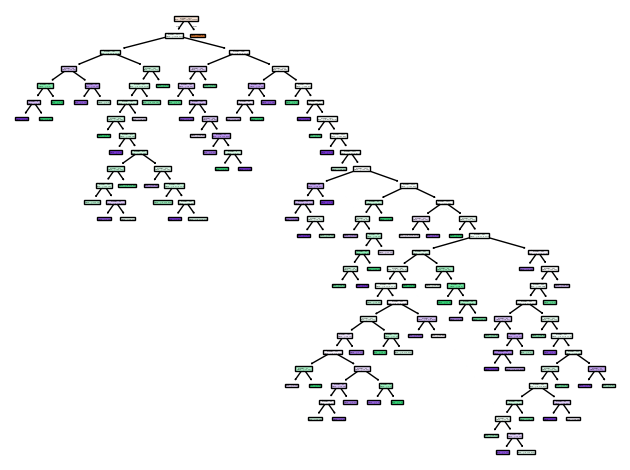

In [ ]:
fig, ax = plt.subplots()
plot_tree(best_tree, filled=True, feature_names=list(pd.DataFrame(X_train_prepd).columns), impurity=False) # opt
fig.tight_layout()

In [ ]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

def print_scores(y_test, y_pred):
    plt.rc("font", size=20)
    # Display confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues, colorbar=False)
    plt.show()

    # Calculate accuracy metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    # Print the scores
    print(f'Accuracy={accuracy:.4f}, Balanced Accuracy={balanced_accuracy:.4f}')
    print(f'Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}')


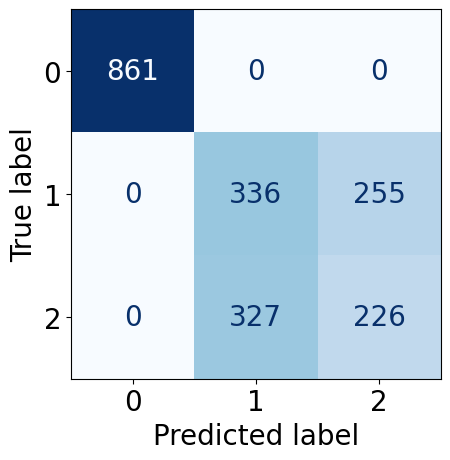

Accuracy=0.7097, Balanced Accuracy=0.6591
Precision=0.6589, Recall=0.6591, F1-score=0.6577


In [ ]:
from sklearn.metrics import balanced_accuracy_score
best_model = grid_search.best_estimator_
y_pred_clf_best = best_model.predict(X_test_prepd)
print_scores(y_test, y_pred_clf_best )

Becuase of the underfitting, we want to try oversampling way to reduce the impact of this problem.

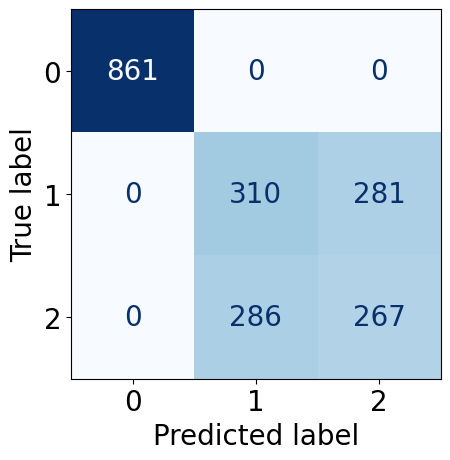

Accuracy=0.7172, Balanced Accuracy=0.6691
Precision=0.6691, Recall=0.6691, F1-score=0.6691


In [ ]:
from sklearn.pipeline import make_pipeline
lr_pipe = make_pipeline(prep_pipeline, DecisionTreeClassifier(class_weight='balanced'))
lr_pipe.fit(X_train_selected, y_train)
y_pred = lr_pipe.predict(X_test_selected)
print_scores(y_test, y_pred)

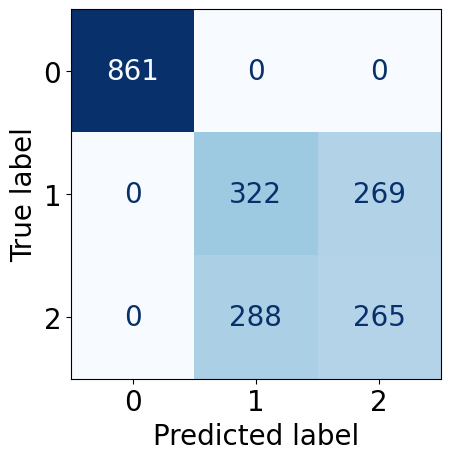

Accuracy=0.7222, Balanced Accuracy=0.6747
Precision=0.6747, Recall=0.6747, F1-score=0.6746


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline

lr_over_pipe = make_pipeline(prep_pipeline, RandomOverSampler(random_state=42), DecisionTreeClassifier())
lr_over_pipe.fit(X_train_selected, y_train)
y_pred = lr_over_pipe.predict(X_test_selected)
print_scores(y_test, y_pred)

The final evaluation of our optimized decision tree model demonstrates an accuracy of 72.22%, which aligns closely with our prior evaluations and expectations. This performance reflects a strong ability to classify Black Friday (Class 0) with perfect precision and recall, but moderate challenges in distinguishing Christmas (Class 1) and Normal Days (Class 2), as indicated by lower recall values. The balanced accuracy of 67.47% underscores the trade-offs between precision across all classes. Overall, the results validate the model's suitability for predicting shopping events while highlighting areas for further refinement to enhance classification for specific classes.

# Step 10: Ensemble Learning for Final Model Selection

Finally, we employed ensemble learning methods to finalize our model selection process. By combining the predictions of multiple classifiers—Logistic Regression, Decision Tree, and Random Forest—we explored two ensemble approaches: Voting and Stacking.

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from xgboost import XGBClassifier

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

voting_clf = VotingClassifier(
    estimators=[
        ('Logistic Regression', logistic_pipeline),
        ('Decision Tree', decision_tree_pipeline),
        ('Random Forest', random_forest_pipeline)
    ],
    voting='soft'
)


voting_clf.fit(X_train, y_train)
voting_accuracy = voting_clf.score(X_test, y_test)
print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")

stacking_clf = StackingClassifier(
    estimators=[
        ('Logistic Regression', logistic_pipeline),
        ('Decision Tree', decision_tree_pipeline),
        ('Random Forest', random_forest_pipeline)
    ],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    cv=5
)

stacking_clf.fit(X_train, y_train)
stacking_accuracy = stacking_clf.score(X_test, y_test)
print(f"Stacking Classifier Accuracy: {stacking_accuracy:.4f}")

Voting Classifier Accuracy: 0.7172


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Stacking Classifier Accuracy: 0.7117


The Voting Classifier combined predictions from Logistic Regression, Decision Tree, and Random Forest models using a soft voting strategy, achieving an accuracy of 71.72%.
The Stacking Classifier, which stacked the predictions of the same base models and utilized a Random Forest as the meta-classifier, delivered an accuracy of 71.17%.
While both methods provided robust performance, the Voting Classifier offered slightly better accuracy, reinforcing its effectiveness in combining the strengths of individual models for predictive tasks. This ensemble approach underscores the importance of leveraging model diversity to improve overall prediction reliability.

# Conclusion

In this project, we successfully developed and evaluated machine learning models to predict shopping event purchase behavior, categorizing data into Black Friday, Christmas, and normal shopping days. The analysis utilized various algorithms, including Logistic Regression, Decision Tree, and Random Forest, with performance enhanced through hyperparameter tuning, feature selection, and ensemble methods like Voting and Stacking classifiers. The final evaluations highlighted the interpretability of the Decision Tree, the robustness of Random Forest, and the effectiveness of ensemble learning in improving predictive accuracy.

The results demonstrated strong performance for Black Friday predictions, with moderate accuracy for the Christmas Market and lower accuracy for Normal Days. These insights reflect the model's ability to uncover distinct shopping behaviors, while also identifying opportunities to improve classification for less distinct categories.

**Business Implications:**

* Black Friday:
The model achieved 100% prediction accuracy for Black Friday shoppers, offering clear opportunities for targeted marketing and operational preparation. Businesses can design aggressive campaigns focused on high-value customers and allocate marketing budgets more effectively. Operationally, infrastructure and logistics should be optimized to handle high sales volumes during peak periods.

* Christmas Market:
Moderate prediction accuracy for the Christmas Market segment suggests the need for refined strategies. Marketing efforts can focus on family-oriented and gift-centric promotions to better engage customers. Resource allocation should emphasize festive product categories, such as decorations and toys, while optimizing for peak evening shopping hours to capitalize on increased demand.

* Normal Days:
Lower prediction accuracy for Normal Days underscores the need to emphasize everyday value and maintain steady sales through loyalty programs and subscription-based services. Streamlining operations and reducing costs can ensure consistent performance on these days.

By aligning marketing strategies and operational planning with predictive insights, businesses can better cater to customer behavior and event-specific trends, driving higher engagement, operational efficiency, and profitability. This process also emphasizes the importance of leveraging machine learning for actionable and data-driven decision-making.

# Challenges
The project faced several challenges that influenced model development and performance:

**1. Class Imbalance:**
The models struggled with predicting minority classes, as evidenced by lower precision and recall for underrepresented categories like Christmas Market and Normal Days. This imbalance impacted the overall performance and fairness of the predictions.

**2. Computational Complexity:** Advanced feature selection methods, such as Sequential Feature Selection, demanded significant computational resources and tuning, increasing the time and complexity of the modeling process.

**3. Convergence Issues:** Some models encountered convergence problems during training, requiring iterative adjustments to hyperparameters and methodologies to achieve stability.

**4. Data Limitations:** External factors, such as market trends, competitors' actions, and promotional schedules, were not included in the dataset. This exclusion likely limited the model's ability to account for real-world influences, reducing its predictive accuracy.

**5. Model-Specific Limitations** Decision Trees divide feature space into axis-aligned regions, which can oversimplify relationships, particularly in datasets with complex, diagonal, or curved decision boundaries.

These limitations highlight opportunities for future work, such as integrating external data sources, refining preprocessing pipelines, or exploring advanced techniques.

# Next Steps
**1. External Data Integration:** Incorporate additional data sources, such as market trends, promotional calendars, and customer feedback, to enrich feature sets.

**2. Real-World Deployment:** Deploy the models in a production environment and measure their impact on business decision-making and outcomes.

**3. Scalability**: Optimize computational efficiency to scale the approach for larger datasets or real-time analysis.

# AI disclosure

1. Data Explanation and Insights: To provide a clear and structured narrative for data analysis, model performance, and evaluation results.
2. Report Writing: To generate draft versions of storylines, summaries, and explanations for key project stages, such as feature selection, hyperparameter tuning, and model evaluation.
3. Content Refinement: To improve the clarity, conciseness, and presentation quality of technical documentation and slides.

While AI tools were employed to support and streamline the workflow, all analyses, decisions, and interpretations of the results were conducted and validated by our team.

# Reference

1. Data Source: Christmas sales and Trends - https://onyxdata.co.uk/data-dna-dataset-challenge/datadna-dataset-archive/
2. Scikit-Learn Documentation: https://scikit-learn.org/stable/documentation.html
3. Matplotlib Documentation: https://matplotlib.org/stable/users/index.html
4. Seaborn Documentation: https://seaborn.pydata.org/


In [ ]:
%%shell
jupyter nbconvert --to html/content/sample_data/BA810_B07_Shopping_Event_Purchase_Prediction.ipynb